# Load the dataset

In [1]:
from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !cp -f /content/gdrive/MyDrive/biomedical_signal_processing/Archive.zip /content/
# !unzip /content/Archive.zip
# !rm -r /content/Archive.zip
# !rm -r /content/__MACOSX
# !pip install eli5

### Import the module

In [3]:
# Data preprocessing
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io
import scipy.stats as stats
import scipy.signal as signal
import pandas as pd

# ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Feature selection
import eli5
from eli5.sklearn import PermutationImportance

# Hyper parameter tunning
from hyperopt import hp
from hyperopt import STATUS_OK, fmin, tpe, Trials
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

### Load the data

(6, 15000, 75)
(6, 15000, 75) (6, 15000, 75)


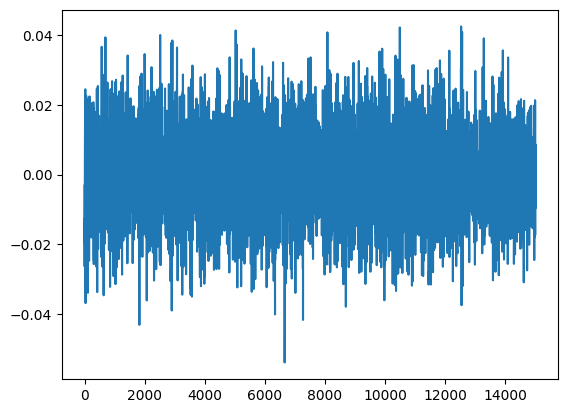

In [4]:
# load mat file
Xva = scipy.io.loadmat("Xva.mat")
Xa = scipy.io.loadmat("Xa.mat")
Rva = Xva['Xva']
Ra = Xa['Xa']

Ra = Ra[6:12, :, :] # Selecting V1 to V6 leads
Rva = Rva[6:12, :, :] # Selecting V1 to V6 leads
print(Ra.shape)

print(Ra.shape, Rva.shape)

plt.plot(Ra[1,:,1])

In [5]:
# load mat file
recur = scipy.io.loadmat("indrecur.mat")
no_recur = scipy.io.loadmat("indnonrecur.mat")
recur = recur['indrecur']
no_recur = no_recur['indnonrecur']

# convert data to list to make it easy to process
recur = recur.flatten().tolist() #
no_recur = no_recur.flatten().tolist()

# change the index for python
recur = [x - 1 for x in recur]
no_recur = [x - 1 for x in no_recur]
print(len(recur), len(no_recur))

32 31


# Machine learning for AF recurrence classification

## Preprocess the data

### Reconstruct data for feature extraction


We should convert the dataset to make it easy to treat. Especially since we analyse ecg of each leads per each signals, here I reconstruct dataset to make 1 row per a signal of a leads and a patient.


In [6]:
def convert_data(X):
    signallist = ['v1','v2','v3','v4','v5','v6']
    formatted_signals = []
    converted_data = {}
    # Iterate through each signal
    for i, signal in enumerate(signallist):
        data = X[i,:,:]
        re_data = data.T
        # Iterate through each patient number
        for patient_num in range(0, X.shape[2]):
            # Format the signal name with the patient number and append to the list
            data_pat = re_data[patient_num,:]
            signal_pat = f"{signal}_{patient_num}"
            converted_data[signal_pat] = data_pat
    return converted_data


To extract informations of r peaks from Rva data, I convert both of Ra and Rva

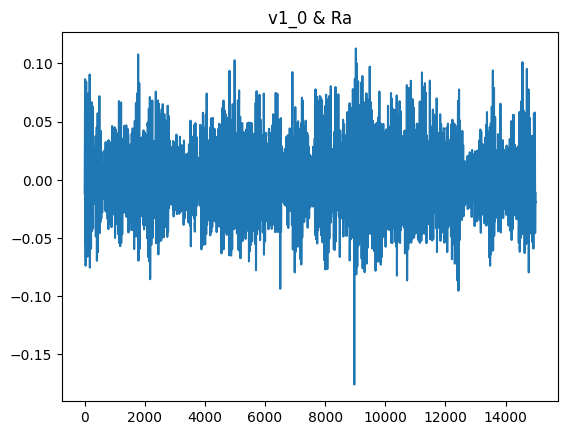

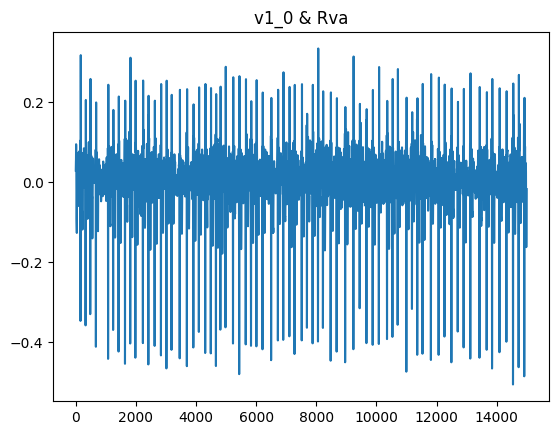

In [7]:
converted_Ra = convert_data(Ra)
converted_Rva = convert_data(Rva)

plt.plot(list(converted_Ra.values())[0])
plt.title(f"{list(converted_Ra.keys())[0]} & Ra")
plt.show()
plt.plot(list(converted_Rva.values())[0])
plt.title(f"{list(converted_Rva.keys())[0]} & Rva")
plt.show()

### Feature extraction

In feature extraction part, my colleagues are collaborated to get meaningful features from each signals. \

I extracted the features by dividing them into four major categories.
* ecg_stat: statistical features extracted for the entire period of each signal.
* diff_stat: "diff" is statistical features extracted from R_peaks of Rva data and based on the distance between locations of R_peaks. The distance between R_peaks can also be expressed as RR intervals, which are later used to calculate the heartbeat rate.
* hr_stat: Statistical features extracted by converting RR interval to Heartbeat Rate.
* seg_stat: Features inspired by tasks 1 to 4 in the lab. This is the average value of statistical features of each segments(cycles) distinguished by r peaks.

In [8]:
def diff_stat(Rva_array):
    x = np.array(Rva_array)
    locs, _ = signal.find_peaks(x, height=x.max()/2)
    if len(locs) >= 2:
        diff = np.diff(locs)    # diff -> RR intervals
        df = pd.DataFrame(data = [diff.max(), diff.min(), diff.mean(), diff.std(),
                                  stats.kurtosis(diff), stats.skew(diff), np.quantile(diff,0.5),
                                  np.quantile(diff, 0.2), np.quantile(diff, 0.8)]).T
        df.columns = ['max_diff', 'min_diff', 'mean_diff', 'sd_diff', 'ku_diff', 'sk_diff', 'median_diff','q20_diff','q80_diff']
    else:
        df = pd.DataFrame(data = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]).T
        df.columns = ['max_diff', 'min_diff', 'mean_diff', 'sd_diff', 'ku_diff', 'sk_diff', 'median_diff','q20_diff','q80_diff']
    return df, locs

def hr_stat(locs):
    RR = np.diff(locs)
    # Convert RR intervals to heart rate
    sampling_frequency = 256  # Sampling frequency in Hz
    HR = 60 * sampling_frequency / RR
    if len(locs) >= 2:
        df = pd.DataFrame(data = [HR.max(), HR.min(), HR.mean(), HR.std(), stats.kurtosis(HR), stats.skew(HR),
                                  np.quantile(HR,0.5), HR.max() - HR.min()]).T
        df.columns = ['max_HR', 'min_HR', 'mean_HR', 'sd_HR', 'ku_HR', 'sk_HR', 'median_HR', 'mode_HR']
    else:
        df = pd.DataFrame(data = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]).T
        df.columns = ['max_HR', 'min_HR', 'mean_HR', 'sd_HR', 'ku_HR', 'sk_HR', 'median_HR', 'mode_HR']
    return df

def seg_stat(Ra_array, locs):
    x = np.array(Ra_array)
    seg_df = pd.DataFrame()
    for i in range(0,len(locs)-1):
        seg =x[locs[i]:locs[i+1]]
        peaks_seg,_ = signal.find_peaks(seg, height=seg.max()/2)
        tmp_df = pd.DataFrame(data = [len(seg), seg.mean(), seg.max(), seg.min(),len(peaks_seg)]).T
        tmp_df.columns = ['len_seg', 'mean_seg', 'max_seg', 'min_seg', 'peaks_seg']
        seg_df = pd.concat([seg_df, tmp_df], axis=0)

    df = pd.DataFrame(seg_df.mean()).T
    return df

def ecg_stat(Ra_array):
    x = np.array(Ra_array)

    df = pd.DataFrame(data = [x.max(), x.min(), np.mean(abs(x)), x.std(),
                              stats.kurtosis(x), stats.skew(x), np.quantile(x,0.5),
                              np.quantile(x, 0.25), np.quantile(x,0.75),
                              np.quantile(x, 0.05), np.quantile(x, 0.95)]).T
    df.columns = ['max_ecg', 'min_ecg', 'meanabs_ecg', 'sd_ecg', 'ku_ecg', 'sk_ecg', 'median_ecg',
                  'q1_ecg', 'q3_ecg', 'q05_ecg', 'q95_ecg']

    return df

def stat_features(Ra, Rva):
    dic_Ra = Ra.copy()
    dic_Rva = Rva.copy()

    names = []
    ecg = pd.DataFrame()
    diff = pd.DataFrame()
    hr = pd.DataFrame()
    seg = pd.DataFrame()
    for i in range(len(Ra)):
        k = list(dic_Ra.keys())[i]
        ra = list(dic_Ra.values())[i]
        rva = list(dic_Rva.values())[i]

        ecg = pd.concat([ecg, ecg_stat(ra)], axis=0)
        diff_tmp, locs_tmp = diff_stat(rva)
        diff = pd.concat([diff, diff_tmp], axis=0)
        hr = pd.concat([hr, hr_stat(locs_tmp)], axis=0)
        seg = pd.concat([seg, seg_stat(ra, locs_tmp)], axis=0)

        df_stat = pd.concat([ecg, diff, hr, seg], axis=1)
        names.append(k)

    df_stat= df_stat.set_axis(names)
    return df_stat

In [9]:
df_stat = stat_features(converted_Ra, converted_Rva)
df_stat

,max_ecg,min_ecg,meanabs_ecg,sd_ecg,ku_ecg,sk_ecg,median_ecg,q1_ecg,q3_ecg,q05_ecg,...,sd_HR,ku_HR,sk_HR,median_HR,mode_HR,len_seg,mean_seg,max_seg,min_seg,peaks_seg
v1_0,0.112801,-0.176020,0.023904,0.029767,0.114096,0.115269,-0.000730,-0.021217,0.019912,-0.046272,...,105.051538,63.853233,8.046023,75.665025,922.074074,207.901408,-0.000093,0.066552,-0.062910,5.985915
v1_1,0.059136,-0.057175,0.012300,0.015474,-0.005221,0.049944,-0.000014,-0.010550,0.010232,-0.025227,...,967.498933,11.227102,3.415401,102.060927,5066.480836,124.091667,0.002040,0.034433,-0.027457,4.891667
v1_2,0.053388,-0.044402,0.010041,0.012656,0.062166,0.111068,-0.000341,-0.008456,0.008327,-0.020794,...,1054.566940,2.300316,1.689708,160.138289,5063.941606,94.202532,0.002004,0.024149,-0.018044,3.525316
v1_3,0.049817,-0.046310,0.009489,0.012080,0.173318,0.083084,-0.000172,-0.007816,0.007716,-0.019636,...,1439.720880,3.042882,1.870175,374.634146,7641.015228,74.457711,0.002629,0.025815,-0.017517,2.572139
v1_4,0.069031,-0.075313,0.013694,0.017488,0.200782,0.077820,-0.000196,-0.011321,0.010885,-0.028689,...,1663.276818,0.445075,0.878192,1536.000000,7647.526427,35.857843,0.005002,0.026463,-0.012631,1.102941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v6_70,0.068409,-0.092659,0.009909,0.013457,3.925464,-0.511300,0.000335,-0.007258,0.008088,-0.020356,...,15.478719,0.774228,0.509455,74.202899,82.530176,208.422535,0.000241,0.033307,-0.037750,6.619718
v6_71,0.102700,-0.087082,0.009492,0.013619,5.717749,-0.002892,0.000055,-0.006930,0.007030,-0.019499,...,13.067077,-0.559920,-0.386479,77.185930,54.977757,217.941176,0.000029,0.037241,-0.039429,4.117647
v6_72,0.120183,-0.073214,0.014416,0.018849,1.342055,0.425637,-0.000759,-0.011676,0.011178,-0.029374,...,23.045783,1.703055,1.306277,96.603774,110.648786,157.797872,0.000255,0.050188,-0.038830,3.085106
v6_73,0.035760,-0.058107,0.006360,0.008318,1.936873,-0.231161,-0.000133,-0.005190,0.005185,-0.012958,...,13.037482,0.160872,-0.667679,66.206897,61.794527,269.236364,-0.000124,0.021456,-0.024912,6.436364


### Make labels and refining data

In this part, I merge the labels with the extracted features and remove the data we don't have the label(12 patients)

In [10]:
# add the label in the dataframe
def make_labels(t_ind, f_ind, df):
    df = df.reset_index()
    df["signal_num"] = np.nan
    df["patient_num"] = np.nan
    df["label"] = np.nan

    for i in range(len(df)):
        patient_num = int(df['index'][i].split('_')[-1])
        df['signal_num'][i] = df['index'][i].split('_')[0]
        df['patient_num'][i] = patient_num
        if patient_num in t_ind:
            df['label'][i] = 1
        elif patient_num in f_ind:
            df['label'][i] = 0
        else:
            df['label'][i] = -1

    df = df.drop('index',axis=1)
    df = df[df['label'] != -1] # remove no labeled data (label =-1)
    return df

df = make_labels(recur,no_recur, df_stat)
df.shape

<ipython-input-10-acbd6151c0a8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal_num'][i] = df['index'][i].split('_')[0]
<ipython-input-10-acbd6151c0a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['patient_num'][i] = patient_num
<ipython-input-10-acbd6151c0a8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][i] = 0
<ipython-input-10-acbd6151c0a8>:13: SettingWithCopyWarning: 
A value is trying to be set

(378, 36)

In [11]:
df.isna().sum() #when r_peak in Rva is under 2, we have nan values. so we remove it for training.

max_ecg         0
min_ecg         0
meanabs_ecg     0
sd_ecg          0
ku_ecg          0
sk_ecg          0
median_ecg      0
q1_ecg          0
q3_ecg          0
q05_ecg         0
q95_ecg         0
max_diff        8
min_diff        8
mean_diff       8
sd_diff         8
ku_diff        10
sk_diff        10
median_diff     8
q20_diff        8
q80_diff        8
max_HR          8
min_HR          8
mean_HR         8
sd_HR           8
ku_HR          10
sk_HR          10
median_HR       8
mode_HR         8
len_seg         8
mean_seg        8
max_seg         8
min_seg         8
peaks_seg       8
signal_num      0
patient_num     0
label           0
dtype: int64

In [12]:
df = df.dropna()  # v1_33, v1_44, v2_33, v2_54, v3_30, v3_33, v4_33, v4_54, v5_33, v5_54
df = df.reset_index().drop('index',axis=1)

df.shape

(368, 36)

In [13]:
# df_grouped = df.drop('signal_num',axis=1).groupby('patient_num').mean()
# df_grouped = df_grouped.reset_index()
# df_grouped

## Train and Evaluate

In traing part, I tried to make baseline model with SVM, Randomforest, XGBoost. And for train-test ratio is 7:3. Since it is not dl approach, i didn't split the validation data(for parameter tuning I used cv)

### Baseline

In [14]:
# Train-Test split
X = df.drop(['label','patient_num','signal_num'], axis=1)
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("train shape:", X_train.shape, y_train.shape)
print("test shape:", X_test.shape, y_test.shape)


train shape: (257, 33) (257,)
test shape: (111, 33) (111,)


#### SVM

Accuracy: 0.5405405405405406
              precision    recall  f1-score   support

         0.0       0.56      0.61      0.59        59
         1.0       0.51      0.46      0.48        52

    accuracy                           0.54       111
   macro avg       0.54      0.54      0.54       111
weighted avg       0.54      0.54      0.54       111



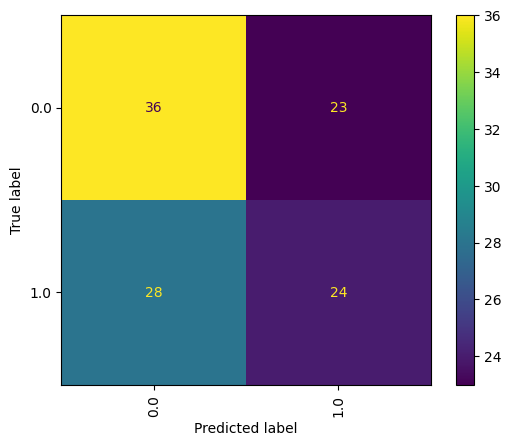

In [15]:
# Initialize and train the SVM
svm_classifier = SVC(kernel='linear')  # Choose linear kernel for simplicity

# Fit the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict AF recurrence
y_pred = svm_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(
    svm_classifier, X_test, y_test, xticks_rotation="vertical"
)

#### Random Forest

Accuracy: 0.7657657657657657
              precision    recall  f1-score   support

         0.0       0.82      0.71      0.76        59
         1.0       0.72      0.83      0.77        52

    accuracy                           0.77       111
   macro avg       0.77      0.77      0.77       111
weighted avg       0.77      0.77      0.77       111



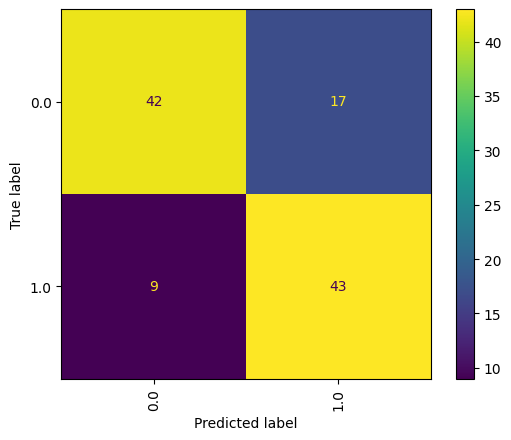

In [16]:
rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train, y_train)

# Predict AF recurrence
y_pred = rfc.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    rfc, X_test, y_test, xticks_rotation="vertical"
)

#### XGBoost

Accuracy: 0.7387387387387387
              precision    recall  f1-score   support

         0.0       0.81      0.66      0.73        59
         1.0       0.68      0.83      0.75        52

    accuracy                           0.74       111
   macro avg       0.75      0.74      0.74       111
weighted avg       0.75      0.74      0.74       111



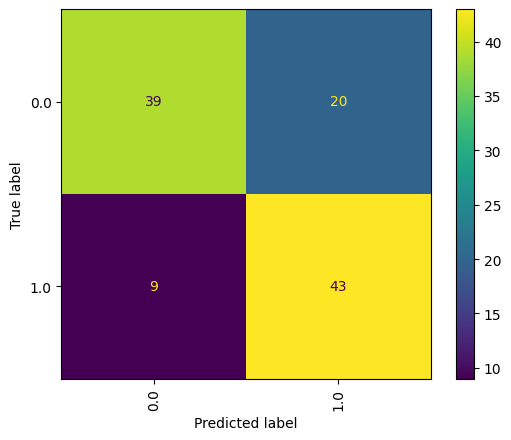

In [17]:
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train, y_train)

# Predict AF recurrence
y_pred = xgb.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    xgb, X_test, y_test, xticks_rotation="vertical"
)

For the baseline model, randomforest classifier has the best accuracy.

### ML with 10 important features with permutation importance

In the baseline model, we used 33 features and it can bring a poor performance with curse of dimmension.
So, here we select important features with permutaion importance.
Permutation importance provides a more robust assessment of feature importance because it directly measures the impact of features on model performance by shuffling them, rather than relying on internal model mechanisms that may vary depending on the model type or dataset characteristics.

In [18]:
# Train-Test split
X = df.drop(['label','patient_num','signal_num'], axis=1)
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("train shape:", X_train.shape, y_train.shape)
print("test shape:", X_test.shape, y_test.shape)

train shape: (257, 33) (257,)
test shape: (111, 33) (111,)


In [19]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

perm = PermutationImportance(rfc, scoring = "accuracy", random_state = 22).fit(X_test, y_test)

pick = ['mean_HR', 'min_HR', 'sk_HR', 'q05_ecg', 'ku_HR', 'median_diff', 'median_HR', 'median_ecg', 'max_diff', 'ku_ecg']
eli5.show_weights(perm, top = 10, feature_names = X_train.columns.tolist())


Weight,Feature
0.0360 ± 0.0161,mean_HR
0.0342 ± 0.0135,min_HR
0.0324 ± 0.0144,sk_HR
0.0288 ± 0.0265,q05_ecg
0.0288 ± 0.0265,ku_HR
0.0270 ± 0.0000,median_diff
0.0252 ± 0.0135,median_HR
0.0234 ± 0.0314,median_ecg
0.0234 ± 0.0144,max_diff
0.0234 ± 0.0088,ku_ecg


Overall, features related to HR showed high importance, followed by ecg and diff.

number of features:  10
selected features:  ['mean_HR', 'min_HR', 'sk_HR', 'q05_ecg', 'ku_HR', 'median_diff', 'median_HR', 'median_ecg', 'max_diff', 'ku_ecg']
Accuracy: 0.7747747747747747
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78        59
         1.0       0.75      0.79      0.77        52

    accuracy                           0.77       111
   macro avg       0.77      0.78      0.77       111
weighted avg       0.78      0.77      0.77       111



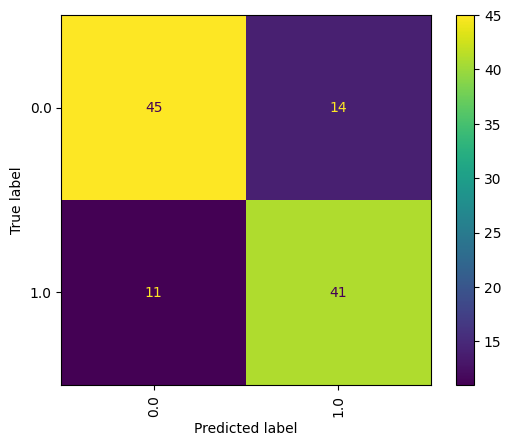

In [20]:
print("number of features: ",len(pick))
print("selected features: ", pick)

X = df[pick]
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Predict AF recurrence
y_pred = rfc.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    rfc, X_test, y_test, xticks_rotation="vertical"
)

With training the random forest classifier with selected features, the performance has improved.

### Parameter tunning

In [21]:
X = df[pick]
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
rfc_search_space={'n_estimators':hp.uniform('n_estimators',100,1000),
                  'max_depth':hp.choice('max_depth', range(1, 30)),
                  'min_samples_leaf':hp.uniform('min_samples_leaf',1,6),
                  'min_samples_split':hp.uniform('min_samples_split',2,6)}


def objective_func(search_space):
    rfc_clf = RandomForestClassifier(n_estimators=int(search_space['n_estimators']),
                                     max_depth=int(search_space['max_depth']),
                                     min_samples_leaf=int(search_space['min_samples_leaf']),
                                     min_samples_split=int(search_space['min_samples_split']),
                                     random_state=42)

    accuracy = cross_val_score(rfc_clf, X_train, y_train, scoring='accuracy', cv=3)

    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [23]:
# trial_val = Trials()
# best = fmin(fn=objective_func,
#             space=rfc_search_space,
#             algo=tpe.suggest,
#             max_evals=50,
#             trials=trial_val, rstate=np.random.default_rng(seed=9))
# print('best:', best)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.7747747747747747
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78        59
         1.0       0.74      0.81      0.77        52

    accuracy                           0.77       111
   macro avg       0.78      0.78      0.77       111
weighted avg       0.78      0.77      0.77       111



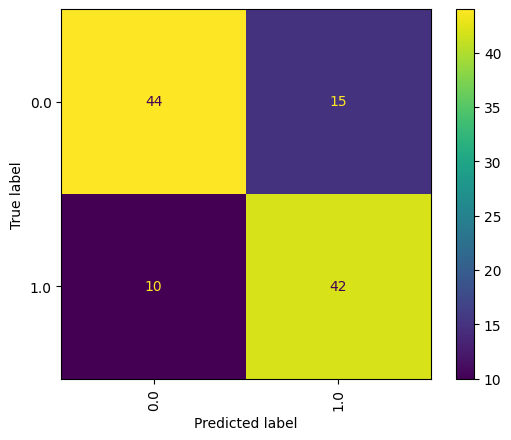

In [24]:
rfc_best = RandomForestClassifier(criterion='gini', max_depth=20, max_features='auto',
                                  min_samples_leaf=1,min_samples_split=2,
                                  n_estimators=500,random_state=42)

rfc_best.fit(X_train, y_train)

# Predict AF recurrence
y_pred = rfc_best.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    rfc_best, X_test, y_test, xticks_rotation="vertical"
)

Parameter tuning does not result in significant performance improvement.

## Conclusion

I got a best model with feature selection with prameter tuning. And the accuracy is 0.77

# ANN for Ventricular activity removal

In [25]:
print(Ra.shape, Rva.shape)

(6, 15000, 75) (6, 15000, 75)


(-0.5, 0.5)

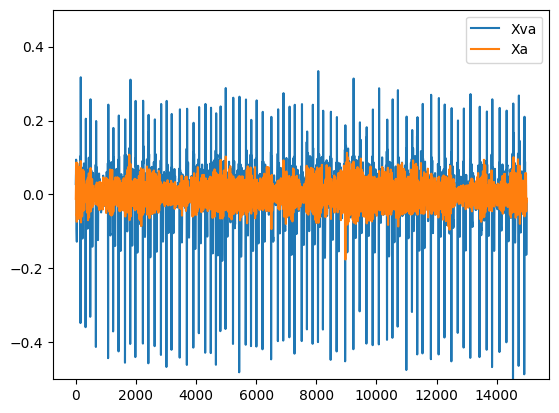

In [26]:
plt.figure()
plt.plot(Rva[0,:,0])
plt.plot(Ra[0,:,0])
plt.legend(['Xva','Xa'],loc='upper right')
plt.ylim([-0.5,0.5])

In [27]:
X_train.shape

(257, 10)

Epoch 1/100
6/6 [==============================] - 5s 45ms/step - loss: 0.0021 - val_loss: 7.6490e-04
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 7.3766e-04
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 7.4024e-04
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 7.1483e-04
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 7.2719e-04
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 7.2614e-04
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 7.3178e-04
Epoch 8/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 7.2486e-04
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 7.2882e-04
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - 

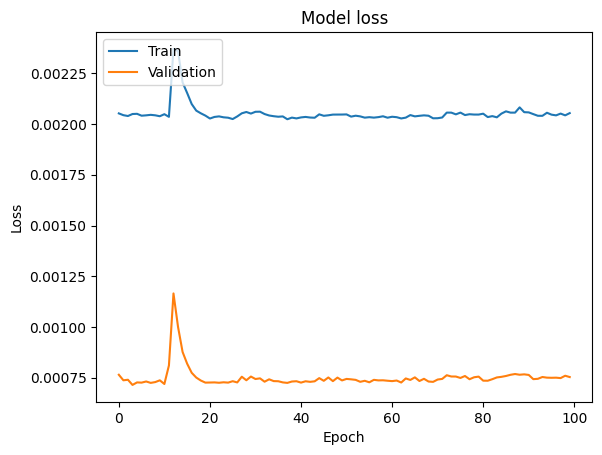

In [28]:
from tensorflow.keras import layers, models


# Reshape the matrices to match the input shape of the neural network
Rva_input = Rva.transpose((1, 0, 2)).reshape((15000, 6 * 75)).T
Ra_true = Ra.transpose((1, 0, 2)).reshape((15000, 6 * 75)).T

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(Rva_input, Ra_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(15000,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(15000, activation='linear'))  # Output layer with linear activation


optimizer = tf.keras.optimizers.Adam(learning_rate=0.03, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

# Training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [29]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Predict with the trained model to predict Ra from Rva for new data
y_pred = model.predict(X_test)
print(f'Test Loss: {loss}')


3/3 [==============================] - 0s 4ms/step
Test Loss: 0.00033961914596147835


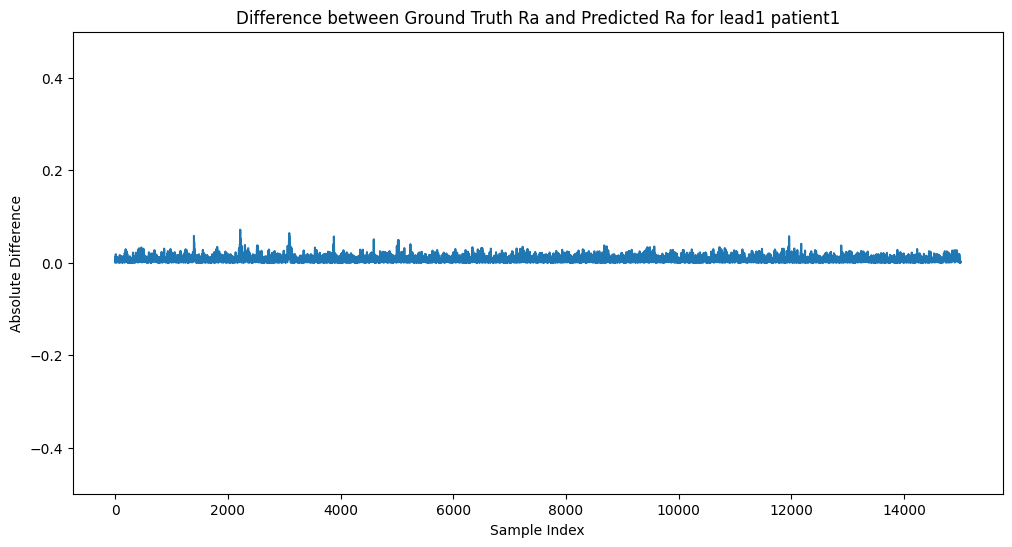

In [30]:
# Calculate the absolute difference between ground truth Ra and predicted Ra
# True_Ra = y_test.reshape(-1, 6, 15000).transpose((1, 2, 0))
difference = abs(y_test - y_pred)
difference = difference.reshape(6,-1,15000).transpose((1, 2, 0))
# Plot the difference for a random patient (you can change the index as needed)
patient_index = 0

plt.figure(figsize=(12, 6))
plt.plot(difference[0, :, patient_index])
plt.ylim([-0.5,0.5])
plt.title('Difference between Ground Truth Ra and Predicted Ra for lead1 patient1')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Difference')
plt.show()

In [31]:
y_pred = y_pred.reshape(6,-1,15000).transpose((1, 2, 0))
y_test = y_test.reshape(6,-1,15000).transpose((1, 2, 0))


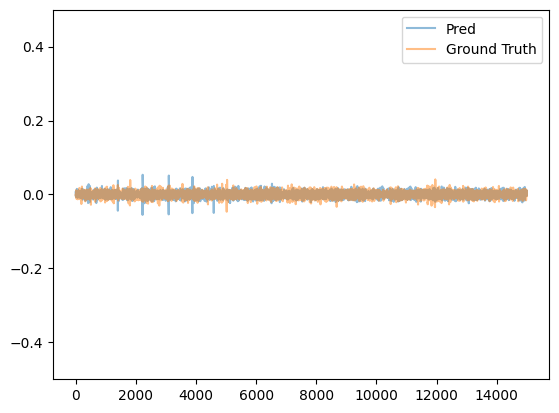

In [32]:
plt.figure()
plt.plot(y_pred[0,:,0],alpha = 0.5)
plt.plot(y_test[0,:,0],alpha = 0.5)
plt.ylim([-0.5,0.5])
plt.legend(['Pred','Ground Truth'],loc='upper right')

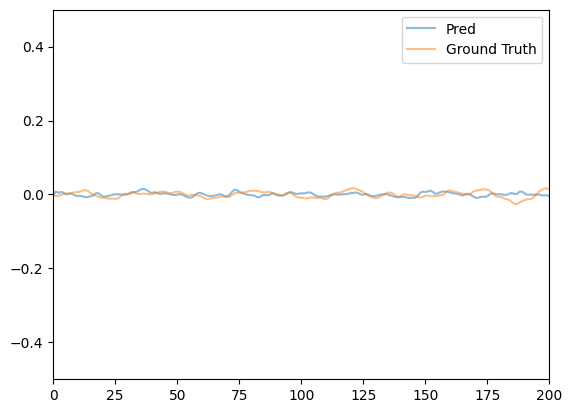

In [33]:
plt.figure()
plt.plot(y_pred[0,:,0],alpha = 0.5)
plt.plot(y_test[0,:,0],alpha = 0.5)
plt.ylim([-0.5,0.5])
plt.xlim([0,200])
plt.legend(['Pred','Ground Truth'],loc='upper right')

I got the model which return loss 0.00033. But, I need to find best structure and optimizer that the model can be converged when it is trained.